## Classification models

###1.Collecting Tweets through Twitter API

Using Twitter API, we can collect information tweets includes user information, date, and tweets. For this, install and import Twitter API first.

In [0]:
!pip install python-twitter
import twitter
import json

import keys.py file that contains twitter API user information to collect tweets from twitter

In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving keys.py to keys (1).py


In [0]:
import keys
api = twitter.Api(consumer_key = keys.consumer_key,
                 consumer_secret = keys.consumer_secret,
                 access_token_key = keys.access_token,
                 access_token_secret = keys.access_token_secret)

In [0]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
  name = fn, length = len(uploaded[fn])))

Saving drug_safety_data.txt to drug_safety_data (1).txt
User uploaded file "drug_safety_data.txt" with length 185065 bytes


Tweets ids and twitter user ids are in 'drug_safety_data.txt' file. 

1. Collect tweets information that we will refer through twitter API
2. The data are stored as json format
3. Text in below shows how it is constructed 

In [0]:
import pandas as pd
drugTweets = pd.read_csv('drug_safety_data.txt', delimiter = '\t', header = None, names = ['tweet_id', 'twitter_user_id', 'abuse'])
drugTweets = drugTweets.drop_duplicates()
drugTweets_text = api.GetStatuses(drugTweets.tweet_id)
txts = []
for tweet in drugTweets_text:
  txts.append(json.loads(json.dumps(tweet._json)))
txts[0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Sun May 12 18:08:41 +0000 2013',
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 333644914913079296,
 'id_str': '333644914913079296',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 0,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'text': 'i know for a FACT that alcohol does not deplete the seroquel levels in your blood, YET HERE WE ARE',
 'truncated': False,
 'user': {'contributors_enabled': False,
  'created_at': 'Fri Dec 24 03:45:56 +0000 2010',
  'default_profile': False,
  'default_profile_image': False,
  'description': 'emma 📌 she/her',
  'entities': {'description

From the json format, take out necessary information such as user_ids and texts

In [0]:
ids = []
text = []
for line in txts:
  ids.append(line['id'])
  text.append(line['text'])

###2.Text pre-processing

Tweets were written in the informal language in most cases, and included reserved words related to Twitter. To improve machine learning models performance, it is required to clean unnecessary text up to teach models clearly. 

####1.Remove Twitter reserved word

In [0]:
!pip install tweet-preprocessor
import preprocessor as p

tweet-preprocessor library supports to remove these text.


1.   URLs
2.   Hashtags
3.   Mentions
4.   Reserved words (RT, FAV)
5.   Emojis
6.   Smileys
7.   Number

In [0]:
text_clean = []
for line in text:
  text_clean.append(p.clean(line))
print('Before : {}'.format(text[1]))
print('After  : {}'.format(text_clean[1]))

Before : @Scribble_Dragon 50 mg Seroquel with my ‘normal’ 60 mg Lovan and 750 mcg Clonazepam.
After  : mg Seroquel with my normal mg Lovan and mcg Clonazepam.


After cleaning twitter reserved words, put this on the data frame that includes tweet_id, user_id and classfication label information.

In [0]:
tweets_w_text = pd.DataFrame(list(zip(ids, text_clean)), columns = ['tweet_id', 'text_text'])
drugTweets_df = pd.merge(tweets_w_text, drugTweets, on = 'tweet_id', how = 'inner')

####2.Stopwords / Lowercase / Stemming

Besides removing Twitter words, we can remove stopwords that would not give important information and lowercase every text for avoiding counting same words several times. Also, we decide to apply stemming to reduce inflected words to their word stem.

In [0]:
import nltk
import re
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'fix_text' function includes removing stopwords, stemming, lowercasing and removing special characters. 

In [0]:
stop_words = set(stopwords.words("english"))
snow = nltk.stem.SnowballStemmer('english')

def fix_Text(text):
	letters_only = re.sub("[^a-zA-Z]"," ", str(text))
	words=letters_only.lower().split()
	meaningful=[snow.stem(word) for word in words if word not in stop_words]
	return(" ".join(meaningful))

In [0]:
num_resp = drugTweets_df["text_text"].size
print("Before : {}".format(drugTweets_df['text_text'][2]))
clean_text = []
for i in range(0,num_resp):
	clean_text.append(fix_Text(drugTweets_df["text_text"][i]))

print("After : {}".format(clean_text[2]))

Before : SEVEN missed calls? get you're seroquel mg lowered. you're getting ridiculous
After : seven miss call get seroquel mg lower get ridicul


Also we found that twitter users use two words for one medicine such and also they type energy drink 'red bull' or 'redbull'. We thought it is reasonable to count these words together. Also, even we removed special characters, broken codes are still in text such as 'amp', 'lt,' and 'gt' because thoese are alphabet characters. So we made a function that change specific words, and remove the broken codes. 

In [0]:
word_list = {'quetiapin' : 'seroquel', 'oxycontin' : 'oxycodone', 'red bull' : 'redbull', 'amp':'', 'lt':'', 'gt':''}

def change_word(text):
  for key in list(word_list.keys()):
    if key in text:
      text = text.replace(key, word_list[key])

  return text

In [0]:
print("Before : {}".format(clean_text[5]))
for i in range(num_resp):
  clean_text[i] = change_word(clean_text[i])

print("After : {}".format(clean_text[5]))

Before : antipsychot quetiapin sedat olanzapin risperidon aripiprazol lithium augment agent
After : antipsychot seroquel sedat olanzapin risperidon aripiprazol lithium augment agent


###3.Document - Term representation

In order to classify tweets by machine learning models, we need to create a document-term representation. Numbers in the matrix represent how important a word is to a document in a collection or corpus.

##### 1.Term Frequency

Using by CountVectorizer function, we can tokenize and count the frequency of words in tweets. After it, fit_transform module creats a Document-Term matrix. 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
tfVectorizer=CountVectorizer()
tfdtm= tfVectorizer.fit_transform(clean_text)
tfVectorizer.get_feature_names()[0:5]

['abbi', 'abid', 'abil', 'abilifi', 'abl']

#### 2.Term Frequency - Inverse Document Frequency (Feature Selection)

The frequency of words does not tell us how the words important, because some not important words such as 'I', 'the', 'a' would frequently appear than other terms. Term Frequency - Inverse Document Frequency value represents priority by the number of appearance in the document / the number of occurrence in the corpus. 

TfidfVectorizer module helps create tfidf matrix and set the minimum number of appearance. After creating the counting vector, convert it to data frame that we are going to use it for classification modeling.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

We then created 3 datasets where only the terms that appeared a minimum of 20, 30 and 50 times respectively would be included. With the minimum term appearance of 20, 226 features were retained for a minimum of 30 terms, 137 features were retained, and with a minimum of 50 term appearances, 67 features were retained. 

We evaluated the result of each frequency before, and 30 reveals the best performance. Thus, we decide to set minimum frequency of words ad 30 here. 

In [0]:
tfidfVectorizer=TfidfVectorizer(min_df=30)
tfidfdtm = tfidfVectorizer.fit_transform(clean_text)
tfidfVectorizer.get_feature_names()[0:5]

['actual', 'adderal', 'addict', 'also', 'ask']

In [0]:
tfidf_df = pd.DataFrame(tfidfdtm.toarray(), columns=tfidfVectorizer.get_feature_names())
tfidf_df[:10]

,actual,adderal,addict,also,ask,ass,back,bad,bed,best,better,call,caus,coffe,come,could,day,doctor,done,dose,drink,drug,eat,effect,even,ever,everi,feel,final,first,focus,friend,fuck,gave,get,give,go,gonna,good,got,...,see,seroquel,shit,sinc,sleep,someon,someth,start,stay,still,stop,studi,sure,surgeri,take,taken,talk,tell,thank,thing,think,thought,time,today,tomorrow,tonight,took,tri,two,use,wake,want,way,week,well,work,would,xanax,yeah,year
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.471828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.268926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.540054,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.691915,0.0,0.0,0.0,0.0,0.0,...,0.0,0.233618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.699267,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.322075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.164738,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270969,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.450173
5,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
6,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.400102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495792,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
7,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.194039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.451086,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.743662,0.0,0.0,0.000000
8,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.458062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.442214,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.205383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.464839,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.453821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
9,0.0,0.000000,0.0,0.0,0.000000,0.0,

In [0]:
drugTweets_df

,tweet_id,text_text,twitter_user_id,abuse
0,333644914913079296,i know for a FACT that alcohol does not deplet...,230052171,0
1,344825926342832128,mg Seroquel with my normal mg Lovan and mcg Cl...,179074771,0
2,333854289023864832,SEVEN missed calls? get you're seroquel mg low...,333099736,0
3,344606561873833985,there's a fella on my Facebook who is asking t...,464202509,1
4,341947615853813761,you take vyvanse? I was on that stuff for like...,90304006,0
...,...,...,...,...
2854,541858163289784320,"I'm hip, but that's what my other tweet is abo...",288784938,1
2855,542031072171933697,My body already hates me for the copious amoun...,360382242,1
2856,541866635964203009,Adderall will make you check twitter plus time...,281287390,0
2857,541998263256485890,"finals week tip: make sure u poop, pee, and ea...",867182059,1


In [0]:
tfidf_df['abused'] = drugTweets_df.abuse

###4.Modeling

Data set for modeling is made through text pre-processing and creating a tf-idf matrix. In this part, we will focus on how to make classfication models.

####1.Import classifiers

Importing classification model packages.

We will train KNN, SVM, Naive Bayes, and Decision tree models, and compare performance.

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

####2.Load DTM File and split as train & test

Use a tf-idf matrix that we made above as dataset.

1.   Take a label column in dataset as y.
2.   Split dataset as training and test set. (Training 80% / Test 20%)

In [0]:
X = tfidf_df.drop('abused', axis = 1)
y = tfidf_df.abused


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)

Check how many abuse tweets do we have on our dataset.

0 is not abused one, and 1 is abused. So, we have about 15% of tweets that were labeled as abused.

We can tell it is imbalanced dataset. 

In [0]:
tfidf_df.abused.value_counts()

0    2432
1     427
Name: abused, dtype: int64

####3.Resampling

If we train models with imbalanced data, the models will be biased to predict majority class which is not aligned to the purpose of this study. In order to resolve this problem, we executed resamplings to make dataset balanced.

We will apply 3 types of resampling and pick the best one.


1. Random Over Sampling
2. Random Under Sampling
3. SMOTE

In [0]:
from sklearn.utils import resample
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Oversampling  (X_train_up, y_train_up)

In [0]:
ros = RandomOverSampler(random_state = 123)
X_train_up, y_train_up = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_up).items()))

[(0, 1941), (1, 1941)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTE (X_train_SMOTE, y_train_SMOTE)

In [0]:
X_train_SMOTE, y_train_SMOTE = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train_SMOTE).items()))

[(0, 1941), (1, 1941)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Undersampling (X_train_under, y_train_under)

In [0]:
rus = RandomUnderSampler(random_state = 123)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_under).items()))

[(0, 346), (1, 346)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


####4.Train and evaluate 

With oversampled data, we will train models, test on those and compare which classification model shows the best performance. 

Here is three functions that we made to work done easily.


*   fit_models - Training four models(KNN, SVM, Decision Tree, Naive Bayes) with oversampled data.
*   compare_model - Predict abused tweets based on the models trained on fit_models function.
*   print_result - Put training and test result as inputs and compare models peformance comfortably.

In [0]:
def fit_models(X_train, y_train):
  
  knn = KNeighborsClassifier()
  svm = SVC(kernel = 'linear', random_state = 123)
  dt = DecisionTreeClassifier(random_state = 123)
  nb = GaussianNB()

  _models = [knn, svm, dt, nb]
  
  classifiers = []
  for classifier in _models:
    classifier.fit(X = X_train, y = y_train)
    classifiers.append(classifier)
    
  return classifiers

In [0]:
def compare_models(classifiers, X, y):

  reports = []
  matrix = []
  
  for _classi in classifiers:
    _predicted = _classi.predict(X = X)
    _report = metrics.classification_report(y, _predicted)
    _matrix = metrics.confusion_matrix(y, _predicted)
    
    reports.append(_report)
    matrix.append(_matrix)
  
  return (reports, matrix)

In [0]:
def print_result(models, train_report, test_report):
  
  for model, train, test in zip(models, train_report, test_report):
    print('{:_<112}'.format(model))
    print('{}  {}  {}'.format('train',' ' * 55, 'test'))
    
    train_lines = train.split('\n')
    test_lines = test.split('\n')
    
    for train_line, test_line in zip(train_lines, test_lines):
      print(train_line + ' ' * 5 + test_line)

In [0]:
models = ['KNN', 'SVM_Linear', 'DecisionTree','NaiveBayesian']

Oversampling Result

In [0]:
_models_up = fit_models(X_train_up, y_train_up)
train_report_up, train_matrix_up = compare_models(_models_up, X_train_up, y_train_up)
test_report_up, test_matrix_up = compare_models(_models_up, X_test, y_test)

In [0]:
print_result(models, train_report_up, test_report_up)

KNN_____________________________________________________________________________________________________________
train                                                           test
              precision    recall  f1-score   support                   precision    recall  f1-score   support
     
           0       0.92      0.73      0.82      1941                0       0.86      0.65      0.74       491
           1       0.78      0.94      0.85      1941                1       0.14      0.36      0.21        81
     
    accuracy                           0.84      3882         accuracy                           0.61       572
   macro avg       0.85      0.84      0.83      3882        macro avg       0.50      0.50      0.47       572
weighted avg       0.85      0.84      0.83      3882     weighted avg       0.76      0.61      0.66       572
     
SVM_Linear______________________________________________________________________________________________________
train          

Undersampling Result

In [0]:
_models_under = fit_models(X_train_under, y_train_under)
train_report_under, train_matrix_under = compare_models(_models_under, X_train_under, y_train_under)
test_report_under, test_matrix_under = compare_models(_models_under, X_test, y_test)

print_result(models, train_report_under, test_report_under)

KNN_____________________________________________________________________________________________________________
train                                                           test
              precision    recall  f1-score   support                   precision    recall  f1-score   support
     
           0       0.76      0.69      0.72       346                0       0.89      0.52      0.65       491
           1       0.71      0.78      0.75       346                1       0.17      0.60      0.27        81
     
    accuracy                           0.73       692         accuracy                           0.53       572
   macro avg       0.74      0.73      0.73       692        macro avg       0.53      0.56      0.46       572
weighted avg       0.74      0.73      0.73       692     weighted avg       0.79      0.53      0.60       572
     
SVM_Linear______________________________________________________________________________________________________
train          

SMOTE Result

In [0]:
_models_SMOTE = fit_models(X_train_SMOTE, y_train_SMOTE)
train_report_SMOTE, train_matrix_SMOTE = compare_models(_models_SMOTE, X_train_SMOTE, y_train_SMOTE)
test_report_SMOTE, test_matrix_SMOTE = compare_models(_models_SMOTE, X_test, y_test)


print_result(models, train_report_SMOTE, test_report_SMOTE)

KNN_____________________________________________________________________________________________________________
train                                                           test
              precision    recall  f1-score   support                   precision    recall  f1-score   support
     
           0       0.89      0.71      0.79      1941                0       0.89      0.60      0.72       491
           1       0.76      0.92      0.83      1941                1       0.18      0.53      0.27        81
     
    accuracy                           0.81      3882         accuracy                           0.59       572
   macro avg       0.83      0.81      0.81      3882        macro avg       0.53      0.57      0.49       572
weighted avg       0.83      0.81      0.81      3882     weighted avg       0.79      0.59      0.65       572
     
SVM_Linear______________________________________________________________________________________________________
train          

###5.Validation

To validate our model, we run cross validation and draw ROC curve.

#### 1.Cross Validation

Since the data is imbalanced, we adopt stratifiedKFold function that keeps class weights on spliiting data for cross validation. Also, we use f1_scorer to compare models by f1_measure, not Accuracy. 

In [0]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

def cross_validation(estimators, folds, X_mat, Y_vec):
   for estimator_name, estimator_object in estimators.items():
      
    f1_scorer = make_scorer(f1_score, pos_label= 1)
    kfolds = StratifiedKFold(n_splits=folds, random_state=123, shuffle=True)
    scores = cross_val_score(estimator=estimator_object, X=X_mat, y=Y_vec, cv=kfolds, scoring = f1_scorer)
    print(f'{estimator_name:>20}: '
          f'mean f1={scores.mean():.2%}; ' +
          f'standard deviation={scores.std():.2%}')

In [0]:
estimators = {
    'knn': KNeighborsClassifier(),
    'svm': SVC(kernel='linear', random_state=123, class_weight = 'balanced'),
    'dt': DecisionTreeClassifier(random_state=123),
    'nb': GaussianNB()
}

In [0]:
X_train_oversampled = pd.DataFrame(X_train_SMOTE, columns = X_test.columns)
oversampled_x = pd.concat([X_test, X_train_oversampled])

In [0]:
y_train_oversampled = pd.Series(y_train_SMOTE)
oversampled_y = y_test.append(y_train_oversampled)

First, cross validation on oversampled data(Oversampled_training + test)

In [0]:
cross_validation(estimators, 10, oversampled_x, oversampled_y)

                 knn: mean f1=76.34%; standard deviation=1.25%
                 svm: mean f1=71.12%; standard deviation=2.49%
                  dt: mean f1=78.90%; standard deviation=1.08%
                  nb: mean f1=70.64%; standard deviation=1.74%


Second, cross validation on Original data(training + test)

In [0]:
cross_validation(estimators, 10, X, y)

                 knn: mean f1=14.28%; standard deviation=6.14%
                 svm: mean f1=35.00%; standard deviation=3.24%
                  dt: mean f1=17.30%; standard deviation=7.01%
                  nb: mean f1=29.99%; standard deviation=2.93%


In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
def svm_param_selection(X, y, nfolds):
  parameter_candidates = [
      {'C':[1,10,100,1000], 'kernel':['linear']}
  ]
  f1_scorer = make_scorer(f1_score, pos_label= 1)
  grid_search = GridSearchCV(estimator = SVC(), param_grid = parameter_candidates, cv = nfolds, scoring = f1_scorer)
  grid_search.fit(X, y)
  grid_search.best_params_
  return grid_search.best_params_

In [0]:
_optimized = svm_param_selection(X_train_SMOTE, y_train_SMOTE, 10)

In [0]:
_optimized

{'C': 1000, 'kernel': 'linear'}

In [0]:
svm = SVC(kernel = 'linear', C = 1000, random_state = 123)
svm.fit(X_train_SMOTE, y_train_SMOTE)
_predicted = svm.predict(X = X_test)
report = metrics.classification_report(y_test, _predicted)
print(report)


              precision    recall  f1-score   support

           0       0.88      0.64      0.74       491
           1       0.18      0.47      0.26        81

    accuracy                           0.61       572
   macro avg       0.53      0.55      0.50       572
weighted avg       0.78      0.61      0.67       572



#### 2.ROC curve

We looked at the Area Under the Curve (AUC) on a ROC graph to future compare the model performance. SVM outperforms the other models here as well.

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [0]:
classifiers = [KNeighborsClassifier(), 
               SVC(kernel='linear', random_state=123, probability=True),
               DecisionTreeClassifier(random_state=123),
               GaussianNB()]


result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
names = ['KNN', 'SVM', 'DT','GausianNB']

for idx in range(len(names)):
    model = classifiers[idx].fit(X_train_SMOTE, y_train_SMOTE)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':names[idx],
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

In [0]:
print(result_table)

  classifiers  ...       auc
0         KNN  ...  0.569875
1         SVM  ...  0.638644
2          DT  ...  0.566468
3   GausianNB  ...  0.579053

[4 rows x 4 columns]


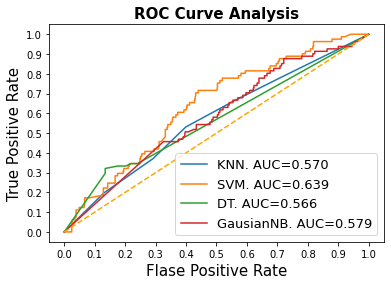

In [0]:
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'], 
             label="{}. AUC={:.3f}".format(result_table.loc[i]['classifiers'] ,result_table.loc[i]['auc']))


plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## Neural Network--CNN/RNN

###1.Import packages and data

To create Neural Network models, import tensorflow and keras in addition to pandas and numpy.

In [0]:
import matplotlib.pyplot as plt
import tensorflow
import keras
from keras import metrics
import numpy as np
from scipy.spatial.distance import cdist
import pandas as pd

Using TensorFlow backend.


Also import 'drugTweets.txt' file that contains user_id, tweets, and classification label.

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving drugTweets.txt to drugTweets (1).txt
User uploaded file "drugTweets.txt" with length 368650 bytes


In [0]:
drugTweets = pd.read_csv('drugTweets.txt', delimiter = "\t", header = 0)

###2.Tokenization & Split Train / Test

In [0]:
from keras.preprocessing.text import Tokenizer

To train the Neural Network model, we tokenize the tweets. We will use the Tokenizer module that cuts tweets by each space and returns a list of words and removes punctuation. We only keep 5000 most frequent words in our vocabulary and can set the number by num_words parameter. Tokenize tweets by fit_on_texts function. This function maps words to the index of a token in a dictionary.

In [0]:
num_words = 5000

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(drugTweets.text_text)


And then, split the dataset to training and testing set by 80/20. Tokenizer module has 'texts_to_sequences' function that creates an index sequence of the sentences. Convert train/test text to index sequences.

In [0]:
test = drugTweets.sample(frac = 0.2, random_state = 123)
train = drugTweets.drop(test.index)

y_train = train.abuse
y_test = test.abuse

x_test_tokens = tokenizer.texts_to_sequences(test.text_text)
x_train_tokens = tokenizer.texts_to_sequences(train.text_text)

###3.Text Padding

In [0]:
from keras.preprocessing.sequence import pad_sequences

All samples must have the same number of dimensions to use Keras. So we should put paddings on short tweets or cut the longer ones. To figure out the appropriate length, calculate the mean length of tweets and 2 standard deviations. We set this number as the length of sampels. 

In [0]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

26

Let's see how many tweets are less than 26 words. About 95.5% of tweets are shorter than 26 words.

In [0]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9559164733178654

We can put paddings on sequences by pad_sequences function. Prior to this, we can decide a position to put padding either 'pre' or 'post' of the sentence.

In [0]:
pad = 'post'

x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)


###4.RNN 

Recurrent Neural Network(RNN) - RNN accepts a concept that you can deliver trained data back to pre-layers by using LSTM(Long Short-Term Memory), so model can understand the sequence of the sentences.

For building a Nueral Networks, import necessary layers, optimizer and regularizers packages.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM, Dropout
from keras.regularizers import l1, l2

from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.utils import class_weight


In [0]:
embedding_size = 64

Here, we build a RNN model. First, create a sequential object that we can stack layers. For RNN, we decide to pile Embedding - Dropout - LSTM - Dropout - Dense layers. Then compile the stack and use Adam as an optimizer. We put Dropout layers and regularizer as much as we can to avoid overfitting. 

In [0]:
rnn = Sequential()

rnn.add(Embedding(input_dim = num_words,
                 output_dim = embedding_size,
                 input_length = max_tokens,
                 name = "embedding_layer"))

rnn.add(Dropout(0.5))

rnn.add(LSTM(units = 16,
            dropout = 0.4,
            kernel_regularizer=l1(0.0001),
            name = 'LSTM_layer'))

rnn.add(Dropout(0.5))
rnn.add(Dropout(0.1))

rnn.add(Dense(units = 1,
             activation = 'sigmoid',
             kernel_regularizer=l2(0.015),
             name = 'Ouput_Layer'))


optimizer = Adam(lr = 0.001, decay = 0.001)

rnn.compile(loss = 'binary_crossentropy',
           optimizer = optimizer,
           metrics = ['accuracy'])

Because the dataset is imbalanced, we will give different weights on labels. class_weight function calculates the weights automatically and we put this into fit function as a parameter.

In [0]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5847868217054264, 1: 3.4485714285714284}

####Training

We decide to set batch_size as 64, and epochs as 4. Batch size the number of samples that will be propagated through the network and epoch is the number of times training data go through networks.

In [0]:
rnn.fit(x_train_pad, y_train, batch_size = 64, validation_split = 0.02, epochs = 2, class_weight = class_weights)
preds_train = rnn.predict_classes(x_train_pad)
print(classification_report(y_train, preds_train, digits = 3))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2365 samples, validate on 49 samples
Epoch 1/2
2365/2365 [==============================] - 2s 689us/step - loss: 0.7620 - accuracy: 0.6879 - val_loss: 0.8758 - val_accuracy: 0.7959
Epoch 2/2
2365/2365 [==============================] - 1s 343us/step - loss: 0.7470 - accuracy: 0.5915 - val_loss: 0.8622 - val_accuracy: 0.2857
              precision    recall  f1-score   support

           0      0.941     0.326     0.484      2064
           1      0.181     0.880     0.301       350

    accuracy                          0.406      2414
   macro avg      0.561     0.603     0.392      2414
weighted avg      0.831     0.406     0.458      2414



#### Test

In [0]:
preds = rnn.predict_classes(x_test_pad)
print(classification_report(y_test, preds, digits = 3))

              precision    recall  f1-score   support

           0      0.872     0.269     0.411       506
           1      0.172     0.794     0.283        97

    accuracy                          0.353       603
   macro avg      0.522     0.531     0.347       603
weighted avg      0.759     0.353     0.390       603



Check confusion_matrix of RNN model.

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, preds)

array([[136, 370],
       [ 20,  77]])

In the code below, return of fit() function stores accuracy/loss of training and validation as the change number of epochs. We can visualize it.

In [0]:
rnn_mod_fit = rnn.fit(x_train_pad, y_train, batch_size=64,
          validation_split=0.05, epochs=20)

Train on 2293 samples, validate on 121 samples
Epoch 1/20
2293/2293 [==============================] - 1s 347us/step - loss: 0.6186 - accuracy: 0.7976 - val_loss: 0.5963 - val_accuracy: 0.7769
Epoch 2/20
2293/2293 [==============================] - 1s 357us/step - loss: 0.4748 - accuracy: 0.8591 - val_loss: 0.5715 - val_accuracy: 0.7769
Epoch 3/20
2293/2293 [==============================] - 1s 344us/step - loss: 0.4545 - accuracy: 0.8591 - val_loss: 0.5557 - val_accuracy: 0.7769
Epoch 4/20
2293/2293 [==============================] - 1s 341us/step - loss: 0.4283 - accuracy: 0.8591 - val_loss: 0.5302 - val_accuracy: 0.7769
Epoch 5/20
2293/2293 [==============================] - 1s 344us/step - loss: 0.3489 - accuracy: 0.8652 - val_loss: 0.5237 - val_accuracy: 0.7769
Epoch 6/20
2293/2293 [==============================] - 1s 342us/step - loss: 0.2975 - accuracy: 0.8801 - val_loss: 0.5502 - val_accuracy: 0.7769
Epoch 7/20
2293/2293 [==============================] - 1s 339us/step - loss:

In [0]:
history_dict = rnn_mod_fit.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Graph in the below, we can see validation loss is increasing as the number of epochs increases. Validation loss is minimized in the validation set at 2.

Next graph shows the change of accuracies, validation accuracy is fluctuating and recored the highest maximum when epoch is 2.

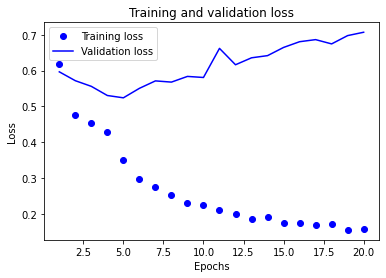

In [0]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

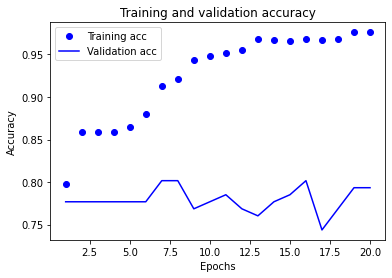

In [0]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###5.CNN

In [0]:
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout

In [0]:
embedding_size = 32

In [0]:
cnn = Sequential()
cnn.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='Embedding_layer'))

cnn.add(Conv1D(filters=32, 
               kernel_size=7, 
               activation='relu',
               name='Conv_Layer'))

cnn.add(GlobalMaxPooling1D(name='Pooling_Layer'))

cnn.add(Dense(units=100,
              activation='relu',
              name='Dense_Layer'))

cnn.add(Dense(units=1,
              activation='sigmoid',
              name='Dense_Output_Layer'))

cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Training

In [0]:
cnn.fit(x_train_pad, y_train, batch_size = 16,
          validation_split=0.02, epochs= 2, class_weight = class_weights)
cnn.evaluate(x_train_pad, y_train)
preds_cnn_train = cnn.predict_classes(x_train_pad)
print(classification_report(y_train, preds_cnn_train, digits=3))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2365 samples, validate on 49 samples
Epoch 1/2
2365/2365 [==============================] - 1s 366us/step - loss: 0.6885 - accuracy: 0.6190 - val_loss: 0.8097 - val_accuracy: 0.5510
Epoch 2/2
2414/2414 [==============================] - 0s 41us/step
              precision    recall  f1-score   support

           0      0.991     0.876     0.930      2064
           1      0.565     0.951     0.709       350

    accuracy                          0.887      2414
   macro avg      0.778     0.914     0.820      2414
weighted avg      0.929     0.887     0.898      2414



#### Testing

In [0]:
cnn.evaluate(x_test_pad, y_test)
cnn_preds = cnn.predict_classes(x_test_pad)
print(classification_report(y_test, cnn_preds, digits=3))

603/603 [==============================] - 0s 53us/step
              precision    recall  f1-score   support

           0      0.902     0.796     0.846       506
           1      0.340     0.546     0.419        97

    accuracy                          0.756       603
   macro avg      0.621     0.671     0.632       603
weighted avg      0.811     0.756     0.777       603



In [0]:
cnn_mod_fit = cnn.fit(x_train_pad, y_train, batch_size=16,
          validation_split=0.05, epochs=20)

Train on 2293 samples, validate on 121 samples
Epoch 1/20
2293/2293 [==============================] - 1s 277us/step - loss: 0.1500 - accuracy: 0.9455 - val_loss: 0.4539 - val_accuracy: 0.8512
Epoch 2/20
2293/2293 [==============================] - 1s 281us/step - loss: 0.0502 - accuracy: 0.9882 - val_loss: 0.4856 - val_accuracy: 0.8430
Epoch 3/20
2293/2293 [==============================] - 1s 283us/step - loss: 0.0161 - accuracy: 0.9978 - val_loss: 0.6405 - val_accuracy: 0.8182
Epoch 4/20
2293/2293 [==============================] - 1s 271us/step - loss: 0.0085 - accuracy: 0.9987 - val_loss: 0.7152 - val_accuracy: 0.8264
Epoch 5/20
2293/2293 [==============================] - 1s 270us/step - loss: 0.0065 - accuracy: 0.9987 - val_loss: 0.7684 - val_accuracy: 0.8182
Epoch 6/20
2293/2293 [==============================] - 1s 270us/step - loss: 0.0105 - accuracy: 0.9978 - val_loss: 0.7608 - val_accuracy: 0.8182
Epoch 7/20
2293/2293 [==============================] - 1s 277us/step - loss:

In [0]:
history_dict = cnn_mod_fit.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

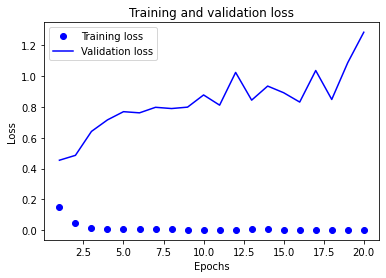

In [0]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

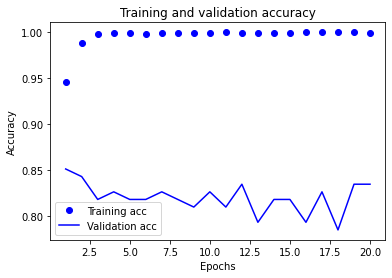

In [0]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()